## 02 - Sampling the Imaginary

#### Imports

In [1]:
# ruff: noqa: F405
from init_notebook import *

%config InlineBackend.figure_formats = ['svg']

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-01-28T22:08:05.907683+04:00

Python implementation: CPython
Python version       : 3.13.1
IPython version      : 8.31.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.4)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas     : 2.2.3
scipy      : 1.15.1
statsmodels: 0.14.4
arviz      : 0.20.0
matplotlib : 3.10.0
xarray     : 2025.1.1
watermark  : 2.5.0
pymc       : 5.20.0
numpy      : 1.26.4



#### Introduction

Suppose there is a blood test that correctly detects vampirism 95% of the time. In more precise and mathematical notation, $P(\text{positive test result}\mid\text{vampire})=0.95$. It’s a very accurate test, nearly always catching real vampires. It also make mistakes, though, in the form of **false positives**. One percent of the time, it incorrectly diagnoses normal people as vampires, $P(\text{positive test result}\mid\text{mortal})=0.01$. The final bit of information we are told is that vampires are rather rare, being only 0.1% of the population, implying $P(\text{vampire})=0.001$. Suppose now that someone tests positive for vampirism. What’s the probability that he or she is a bloodsucking immortal?

|                  | Vampire | Mortal  |
|------------------|---------|--------|
| Test Vampire     | 0.95    | 0.01   |
| Test Not Vampire | 0.05    | 0.99   |

$$P(\text{Vampire} \mid \text{Positive}) = \frac{P(\text{Positive} \mid \text{Vampire})P(\text{Vampire})}{P(\text{Positive})}$$

- $P(\text{Vampire}) = 0.001$
- $P(\text{Positive} \mid \text{Vampire}) = 0.95$
- $P(\text{Positive}) = P(\text{Positive} \mid \text{Vampire})P(\text{Vampire}) + P(\text{Positive} \mid \text{Mortal})P(\text{Mortal})$
- $P(\text{Positive} \mid \text{Mortal}) = 0.01$ (False Positive)
- $P(\text{Positive}) = (0.95)(0.001) + (0.01)(0.999)$

That corresponds to an 8.7% chance that the suspect is actually a vampire.

In [2]:
pr_positive_vampire = 0.95
pr_positive_mortal = 0.01
pr_vampire = 0.001
pr_positive = pr_positive_vampire * pr_vampire + \
              pr_positive_mortal * (1 - pr_vampire)

pr_vampire_positive = pr_positive_vampire * pr_vampire / pr_positive

print(f'P(Vampire | Positive) = {pr_vampire_positive:.2%}')

P(Vampire | Positive) = 8.68%


Most people find this result counterintuitive. And it’s a very important result, because it mimics the structure of many realistic testing contexts, such as HIV and DNA testing, criminal profiling, and even statistical significance testing. Whenever the condition of interest is very rare, having a test that finds all the true cases is still no guarantee that a positive result carries much information at all. The reason is that **most positive results are false positives, even when all the true positives are detected correctly**.

Suppose that instead of reporting probabilities, as before, we are told the following:
1) In a population of 100,000 people, 100 of them are vampires.
2) Of the 100 who are vampires, 95 of them will test positive for vampirism.
3) Of the 99,900 mortals, 999 of them will test positive for vampirism.

If we test all 100,000 people, what proportion of those who test positive for vampirism actually are vampires? Now we can just count up the number of people who test positive: $95 +999 =1094$. Out of these 1094 positive tests, 95 of them are real vampires, so that implies:
$$P(\text{Vampire} \mid \text{Positive}) = \frac{95}{1094} \approx 0.087$$

It’s exactly the same answer as before, but without a seemingly arbitrary rule. The second presentation of the problem, using counts rather than probabilities, is often called the *frequency format* or *natural frequencies*. 

In this notebook we exploit the intuitive frequency format by taking the probability distributions and sampling from them to produce counts. The posterior distribution is a probability distribution. And like all probability distributions, we can imagine drawing samples from it. The sampled events in this case are parameter values. Most parameters have no exact empirical realization. The Bayesian formalism treats parameter distributions as relative plausibility, not as any physical random process. In any event, randomness is always a property of information, never of the real world. But inside the computer, parameters are just as empirical as the outcome of a coin flip or a die toss or an agricultural experiment. The posterior defines the expected frequency that different parameter values will appear, once we start plucking parameters out of it.

**Why statistics can’t save bad science**

The vampirism example has the same logical structure as many different **signal detection problems**: (1) There is some binary state that is hidden from us; (2) we observe an imperfect cue of the hidden state; (3) we (should) use Bayes’ theorem to logically deduce the impact of the cue on our uncertainty. 

Scientific inference is sometimes framed in similar terms: (1) An hypothesis is either true or false; (2) we get a statistical cue of the hypothesis’ falsity; (3) we (should) use Bayes’ theorem to logically deduce the impact of the cue on the status of the hypothesis. It’s the third step that is hardly ever done. But let’s consider a toy example. Suppose the probability of a positive finding, when an hypothesis is true, is $P(\text{sig}|\text{true})=0.95$. That’s the power of the test. Suppose that the probability of a positive finding, when an hypothesis is false, is $P(\text{sig}|\text{false})=0.05$. That’s the false-positive rate, like the 5% of conventional significance testing. Finally, we have to state the base rate at which hypotheses are true. Suppose for example that 1 in every 100 hypotheses turns out to be true. Then $P(\text{true})=0.01$. No one knows this value, but the history of science suggests it’s small.

Now compute the posterior:
$$P(\text{true} \mid \text{pos}) = \frac{P(\text{pos} \mid \text{true})P(\text{true})}{P(\text{pos})} = \frac{P(\text{pos} \mid \text{true})P(\text{true})}{P(\text{pos} \mid \text{true})P(\text{true}) + P(\text{pos} \mid \text{false})P(\text{false})}$$

Plug in the appropriate values, and the answer is approximately $P(\text{true}|\text{pos})=0.16$. So a positive finding corresponds to a 16% chance that the hypothesis is true. This is the same low base-rate phenomenon that applies in medical (and vampire) testing. You can shrink the false-positive rate to 1% and get this posterior probability up to 0.5, only as good as a coin flip. The most important thing to do is to improve the base rate, $P(\text{true})$, and that requires thinking, not testing.

In [3]:
pr_positive_true = 0.95 
pr_true = 0.01
pr_positive_false = 0.05
pr_positive = pr_positive_true * pr_true + pr_positive_false * (1 - pr_true)

pr_true_positive = (pr_positive_true * pr_true) / pr_positive

print(f'P(True | Positive) = {pr_true_positive:.2%}')

P(True | Positive) = 16.10%


Many are uncomfortable with integral calculus. Working with samples transforms a problem in calculus into a problem in data summary, into a frequency format problem. An integral in a typical Bayesian context is just the total probability in some interval. That can be a challenging calculus problem. But once you have samples from the probability distribution, it’s just a matter of counting values in the interval. An empirical attack on the posterior allows on to ask and answer more questions about the model, without relying upon a captive mathematician. For this reason, it is easier and more intuitive to work with samples from the posterior, than to work with probabilities and integrals directly.

Some of the most capable methods of computing the posterior produce nothing but samples. Many of these methods are variants of Markov chain Monte Carlo techniques.

#### Sampling from a Grid-Approximation Posterior

The below code computes the posterior for a model using grid approximation. Remember, the posterior here means the probability of $p$ conditional on the data.

In [4]:
def uniform_prior(grid_points):
    """
    Returns Uniform prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Uniform density of prior values
    """
    return np.repeat(1, grid_points)

def binom_post_grid_approx(prior_func, grid_points=5, k=6, n=9):
    """
    Returns the grid approximation of posterior distribution with binomial likelihood.

            Parameters:
                    prior_func (function): A function that returns the likelihood of the prior
                    grid_points (int): Number of points in the prior grid
                    k (int): Number of successes
                    n (int): Number of tosses

            Returns:
                    p_grid (numpy.array): Array of prior values
                    likelihood (numpy.array): array of likelihood at each point in the grid
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior_func(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(k, n, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, likelihood, posterior

In [5]:
def beta_post_approx(grid_points=5, k=6, n=9, alpha_prior=1, beta_prior=1):
    """
    Beta posterior approximation with uniform prior.

            Parameters:
                    grid_points (int): Number of points in the prior grid
                    k (int): Number of successes
                    n (int): Number of tosses
                    alpha_prior (int): Shape parameter 1 for the beta prior (default is 1 for uniform prior)
                    beta_prior (int): Shape parameter 2 for the beta prior (default is 1 for uniform prior)

            Returns:
                    p_grid (numpy.array): Array of prior values
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)
    
    k = 6  # Number of successes
    n = 9  # Number of trials
    alpha = k + alpha_prior  # Beta shape parameter 1
    beta = n - k + beta_prior  # Beta shape parameter 2    

    # compute likelihood at each point in the grid
    posterior = stats.beta.pdf(p_grid, alpha, beta)

    return p_grid, posterior

In [6]:
p_grid, _, posterior = binom_post_grid_approx(uniform_prior, grid_points=1_000, k=6, n=9)

# np.random.seed(10)
samples = np.random.choice(p_grid, size=10_000, replace=True, p=posterior)
samples

array([0.50650651, 0.65065065, 0.63663664, ..., 0.6026026 , 0.53553554,
       0.64064064])

Now we wish to draw 10,000 samples from this posterior. Imagine the posterior is a bucket full of parameter values, numbers such as 0.1, 0.7, 0.5, 1, etc. Within the bucket, each value exists in proportion to its posterior probability, such that values near the peak are much more common than those in the tails. We’re going to scoop out 10,000 values from the bucket. Provided the bucket is well mixed, the resulting samples will have the same proportions as the exact posterior density. Therefore the individual values of $p$ will appear in our samples in proportion to the posterior plausibility of each value.

The workhorse here is `np.random.choice`, which randomly pulls values from a vector. The vector in this case is `p_grid`, the grid of parameter values. The probability of each value is given by `posterior`, which we computed just above.

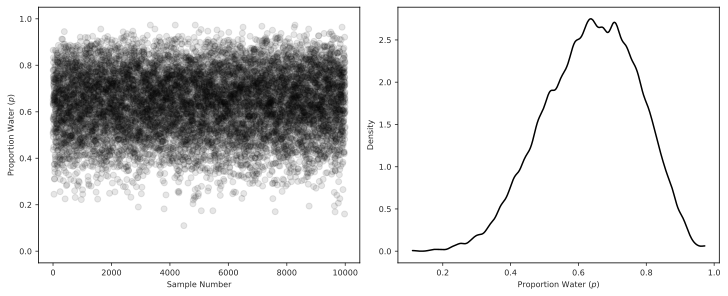

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(samples, 'ko', alpha=0.1)
ax[0].set_xlabel('Sample Number')
ax[0].set_ylabel('Proportion Water ($p$)')
ax[0].set_ylim(-0.05,1.05)
ax[0].spines[['right', 'top']].set_visible(True)
az.plot_kde(samples, plot_kwargs={'color': 'black', 'linestyle': '-'}, ax=ax[1])
ax[1].set_xlabel('Proportion Water ($p$)')
ax[1].set_ylabel('Density')
ax[1].spines[['right', 'top']].set_visible(True);

**Sampling parameter values from the posterior distribution**. Left: 10,000 samples from the posterior implied by the globe tossing data and model. Right: The density of samples (vertical) at each parameter value (horizontal).

In this plot, it’s as if you are flying over the posterior distribution, looking down on it. There are many more samples from the dense region near 0.6 and very few samples below 0.25. On the right, the plot shows the density estimate computed from these samples.

You can see that the estimated density is very similar to ideal posterior you computed via grid approximation. If you draw even more samples, maybe 1e5 or 1e6, the density estimate will get more and more similar to the ideal.

All you’ve done so far is crudely replicate the posterior density you had already computed. That isn’t of much value. But next it is time to use these samples to describe and understand the posterior. That is of great value.

#### Sampling to Summarize

Once your model produces a posterior distribution, the model’s work is done. But your work has just begun. It is necessary to summarize and interpret the posterior distribution. Exactly how it is summarized depends upon your purpose. But common questions include:

- How much posterior probability lies below some parameter value?
- How much posterior probability lies between two parameter values?
- Which parameter value marks the lower 5% of the posterior probability?
- Which range of parameter values contains 90% of the posterior probability?
- Which parameter value has highest posterior probability?

These simple questions can be usefully divided into questions about (1) intervals of **defined boundaries**, (2) questions about intervals of **defined probability mass**, and (3) questions about **point estimates**. We’ll see how to approach these questions using samples from the posterior.

##### Intervals of Defined Boundaries

Suppose I you are asked for the posterior probability that the proportion of water is less than 0.5. Using the grid-approximate posterior, you can just add up all of the probabilities, where the corresponding parameter value is less than 0.5:

In [8]:
# add up posterior probability where p < 0.5
np.sum(posterior[p_grid < 0.5])

0.17187458902022873

In [9]:
# Parameters for the Beta distribution
k = 6  # Number of successes
n = 9  # Number of trials
alpha = k + 1  # Beta shape parameter 1
beta = n - k + 1  # Beta shape parameter 2

# Theoretical - Probability density function
stats.beta.cdf(0.5, alpha, beta)

0.171875

So about 17% of the posterior probability is below 0.5. Couldn’t be easier. But since grid approximation isn’t practical in general, it won’t always be so easy. Once there is more than one parameter in the posterior distribution, even this simple sum is no longer very simple.

Let’s see how to perform the same calculation, using samples from the posterior. This approach does generalize to complex models with many parameters, and so you can use it everywhere. All you have to do is similarly add up all of the samples below 0.5, but also divide the resulting count by the total number of samples. In other words, find the frequency of parameter values below 0.5:

In [10]:
np.sum(samples < 0.5) / 1e4

0.1718

And that’s nearly the same answer as the grid approximation provided, although your answer will not be exactly the same, because the exact samples you drew from the posterior will be different. This region is shown in the upper-left plot below. 

Using the same approach, you can ask how much posterior probability lies between 0.5 and 0.75:

In [11]:
np.sum(posterior[(p_grid > 0.5) & (p_grid < 0.75)])

0.6045851774160315

In [12]:
# Theoretical - Interval Probability density function
stats.beta.cdf(0.75, alpha, beta) - stats.beta.cdf(0.5, alpha, beta)

0.6040000915527344

In [13]:
np.sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6061

So about 61% of the posterior probability lies between 0.5 and 0.75. This region is shown in the upper-right plot below.

##### Intervals of Defined Mass

It is more common to see scientific journals reporting an interval of defined mass, usually known as a **confidence interval**. An interval of posterior probability, such as the ones we are working with, may instead be called a **credible interval**. We’re going to call it a **compatibility interval** instead, in order to avoid the unwarranted implications of “confidence” and “credibility.” What the interval indicates is a range of parameter values compatible with the model and data. The model and data themselves may not inspire confidence, in which case the interval will not either.

These posterior intervals report two parameter values that contain between them a specified amount of posterior probability, a **probability mass**. For this type of interval, it is easier to find the answer by using samples from the posterior than by using a grid approximation. Suppose for example you want to know the boundaries of the lower 80% posterior probability. You know this interval starts at $p=0$. To find out where it stops, think of the samples as data and ask where the 80th percentile lies.

In [14]:
np.quantile(samples, q=0.8)

0.7597597597597597

In [15]:
cum_density_posterior = np.cumsum(posterior)
i_idx = np.searchsorted(cum_density_posterior, 0.8, side='right')
p_grid[i_idx]

0.7607607607607607

In [16]:
stats.beta.ppf(0.8, alpha, beta)

0.7605587778957529

Similarly, the middle 80% interval lies between the 10th percentile and the 90th percentile. These boundaries are found using the same approach.

In [17]:
np.quantile(samples, q=[0.1, 0.9])

array([0.45145145, 0.81181181])

In [18]:
stats.beta.interval(0.8, alpha, beta)

(0.4482691676164009, 0.8124377033526619)

In [19]:
cum_density_posterior = np.cumsum(posterior)
i_start_idx = np.searchsorted(cum_density_posterior, 0.1, side='right')
i_end_idx = np.searchsorted(cum_density_posterior, 0.9, side='right')
p_grid[i_start_idx], p_grid[i_end_idx]

(0.44844844844844844, 0.8128128128128128)

In [20]:
def compute_mass_interval(p_grid, posterior, i_start, i_end):
    """
    Compute the interval bounds and indices for a given mass interval.

    Parameters:
        p_grid (np.array): The grid of parameter values.
        posterior (np.array): The posterior probabilities corresponding to p_grid. 
                              Ensure the posterior is normalized
        i_start (float): The lower quantile (e.g., 0.1 for 10%).
        i_end (float): The upper quantile (e.g., 0.9 for 90%).

    Returns:
        i_start (float): The lower bound of the interval.
        i_end (float): The upper bound of the interval.
        i_indices (np.array): Boolean array indicating the indices of p_grid within the interval.
    """
    
    # Compute the cumulative distribution function (CDF)
    cdf = np.cumsum(posterior)
    
    # Find the indices corresponding to the quantiles
    i_start_idx = np.searchsorted(cdf, i_start, side='right')
    i_end_idx = np.searchsorted(cdf, i_end, side='right')
    
    # Get the x-values corresponding to these indices
    i_start = p_grid[i_start_idx]
    i_end = p_grid[i_end_idx]
    
    return i_start, i_end

In [21]:
def compute_hdi(p_grid, posterior, hdi_prob=0.95):
    """
    Compute the Highest Density Interval (HDI) from grid of parameter values and its posterior.

    Parameters:
        p_grid (np.array): The grid of parameter values.
        posterior (np.array): The posterior probabilities corresponding to p_grid.
                              Ensure the posterior is normalized.
        hdi_prob (float): The probability mass to include in the HDI (e.g., 0.95 for 95% HDI).

    Returns:
        hdi_min (float): The lower bound of the HDI.
        hdi_max (float): The upper bound of the HDI.
    """
    
    # Sort the posterior and p_grid in descending order of posterior density
    sorted_indices = np.argsort(posterior)[::-1]
    sorted_posterior = posterior[sorted_indices]
    sorted_p_grid = p_grid[sorted_indices]
    
    # Compute the cumulative sum of the sorted posterior
    cumulative_posterior = np.cumsum(sorted_posterior)
    
    # Find the smallest set of points that contain the desired probability mass
    n_points = np.argmax(cumulative_posterior >= hdi_prob) + 1
    
    # Get the corresponding p_grid values for the HDI
    hdi_p_grid = sorted_p_grid[:n_points]
    
    # The HDI is the smallest interval in p_grid that contains these points
    hdi_min = np.min(hdi_p_grid)
    hdi_max = np.max(hdi_p_grid)
    
    return hdi_min, hdi_max

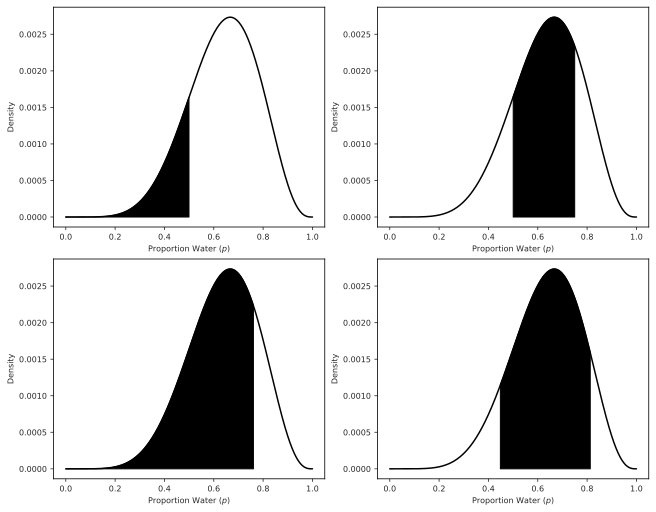

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
intervals = [(0, 0.5001), 
             (0.5, 0.7501), 
             (0.0, 0.8), 
             (0.1, 0.9)]
for ii in range(4):
    ax = axs[ii // 2][ii % 2]
    ax.plot(p_grid, posterior, color='k')
    i_start, i_end = intervals[ii]
    if ii < 2:
        # Intervals of defined boundaries 
        i_indices = (p_grid >= i_start) & (p_grid <= i_end)        
    else:
        # Intervals of defined mass
        i_start, i_end = compute_mass_interval(p_grid, posterior, i_start, i_end)
        # Get the indices for the x-axis values within the interval
        i_indices = (p_grid >= i_start) & (p_grid <= i_end)
    ax.fill_between(p_grid[i_indices], y1=0, y2=posterior[i_indices], color='k')
    ax.set_xlabel('Proportion Water ($p$)')
    ax.set_ylabel('Density')
    ax.spines[['right', 'top']].set_visible(True)

Two kinds of posterior interval. Top row: *Intervals of defined boundaries*. Top-left: The black area is the posterior probability below a parameter value of 0.5. Top-right: The posterior probability between 0.5 and 0.75. Bottom row: *Intervals of defined mass*. Bottom-left: Lower 80% posterior probability exists below a parameter value of about 0.76. Bottom-right: Middle 80% posterior probability lies between the 10% and 90% quantiles.

Intervals of this sort, which **assign equal probability mass to each tail**, are very common in the scientific literature. We’ll call them **percentile intervals (PI)**. These intervals do a good job of communicating the shape of a distribution, as long as the distribution isn’t too asymmetrical. But in terms of supporting inferences about which parameters are consistent with the data, they are not perfect. Consider the posterior distribution and different intervals below. This posterior is consistent with observing three waters in three tosses and a uniform (flat) prior. It is highly skewed, having its maximum value at the boundary, $p =1$. You can compute it, via grid approximation, with:

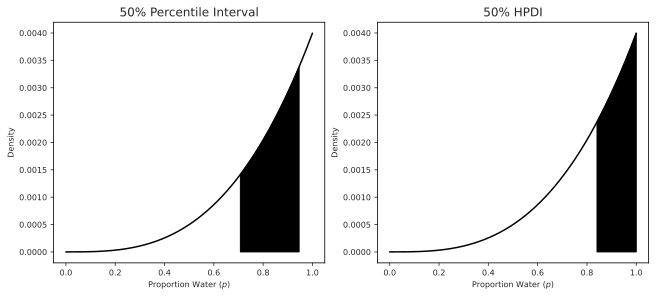

In [23]:
p_grid, _, posterior = binom_post_grid_approx(uniform_prior, grid_points=1000, k=3, n=3)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
intervals = [(0.25, 0.8), 
             (0.5, 0.9999)]
title = ['50% Percentile Interval', '50% HPDI']
for ii in range(2):
    ax = axs[ii]
    ax.plot(p_grid, posterior, color='k')
    
    i_start, i_end = compute_mass_interval(p_grid, posterior, intervals[ii][0], intervals[ii][1])
    i_indices = (p_grid >= i_start) & (p_grid <= i_end)
    
    ax.fill_between(p_grid[i_indices], y1=0, y2=posterior[i_indices], color='k')
    ax.set_xlabel('Proportion Water ($p$)')
    ax.set_ylabel('Density')
    ax.set_title(title[ii])
    ax.spines[['right', 'top']].set_visible(True)

The difference between percentile and highest posterior density compatibility intervals. The posterior density here corresponds to a flat prior and observing three water samples in three total tosses of the globe. Left: 50% percentile interval. This interval assigns equal mass (25%) to both the left and right tail. As a result, it omits the most probable parameter value, $p=1$. Right: 50% highest posterior density interval, HPDI. This interval finds the narrowest region with 50% of the posterior probability. Such a region always includes the most probable parameter value.

The 50% percentile compatibility interval is shaded. You can conveniently compute this from the samples by computing the cumulative density function or by using `np.percentile`. 

In [24]:
# Compute from posterior
compute_mass_interval(p_grid, posterior, 0.25, 0.75)

(0.7077077077077077, 0.9309309309309309)

In [25]:
# Theoretical Interval
# Parameters for the Beta distribution
k = 3  # Number of successes
n = 3  # Number of trials
alpha = k + 1  # Beta shape parameter 1
beta = n - k + 1  # Beta shape parameter 2

stats.beta.interval(0.5, a=alpha, b=beta)

(0.7071067811865476, 0.9306048591020996)

In [26]:
# Compute from sample
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
np.percentile(samples, [25, 75])

array([0.69944945, 0.93193193])

This interval assigns 25% of the probability mass above and below the interval. So it provides the central 50% probability. But in this example, it ends up excluding the most probable parameter values, near p =1. So in terms of describing the shape of the posterior distribution—which is really all these intervals are asked to do—the percentile interval can be misleading.

In contrast, the right-hand plot displays the 50% **highest posterior density interval**  (HPDI). The HPDI is the narrowest interval containing the specified probability mass. If you think about it, there must be an infinite number of posterior intervals with the same mass. But if you want an interval that best represents the parameter values most consistent with the data, then you want the densest of these intervals. That’s what the HPDI is. Compute it from the samples with ArviZ's HDI function.

In [27]:
az.hdi(samples, hdi_prob=0.5)

array([0.83883884, 0.998999  ])

In [28]:
compute_hdi(p_grid, posterior, hdi_prob=0.5)

(0.8408408408408409, 1.0)

This interval captures the parameters with highest posterior probability, as well as being noticeably narrower: 0.16 in width rather than 0.23 for the percentile interval.`

So the HPDI has some advantages over the PI. But in most cases, these two types of interval are very similar. They only look so different in this case because the posterior distribution is highly skewed. If we instead used samples from the posterior distribution for six waters in nine tosses, these intervals would be nearly identical. When the posterior is bell shaped, it hardly matters which type of interval you use. 

In [29]:
p_grid, _, posterior = binom_post_grid_approx(uniform_prior, grid_points=1_000, k=6, n=9)
samples = np.random.choice(p_grid, size=10_000, replace=True, p=posterior)

print('PI (sample) =', np.percentile(samples, [25, 75]))
print('HDPI (sample) =', az.hdi(samples, hdi_prob=0.5))
print('PI (posterior) =', compute_mass_interval(p_grid, posterior, 0.25, 0.75))
print('HDPI (posterior) =', compute_hdi(p_grid, posterior, hdi_prob=0.5))
print('PI (theoratical) =', stats.beta.interval(0.5, a=6+1, b=9 - 6 + 1))

print()
print('PI (sample) =', np.percentile(samples, [5, 95]))
print('HDPI (sample) =', az.hdi(samples, hdi_prob=0.95))
print('PI (posterior) =', compute_mass_interval(p_grid, posterior, 0.05, 0.95))
print('HDPI (posterior) =', compute_hdi(p_grid, posterior, hdi_prob=0.95))
print('PI (theoratical) =', stats.beta.interval(0.9, a=6+1, b=9 - 6 + 1))

PI (sample) = [0.54254254 0.73873874]
HDPI (sample) = [0.56456456 0.75575576]
PI (posterior) = (0.5425425425425425, 0.7387387387387387)
HDPI (posterior) = (0.5645645645645646, 0.7587587587587588)
PI (theoratical) = (0.5423038454251481, 0.7391494116737936)

PI (sample) = [0.39334334 0.84984985]
HDPI (sample) = [0.36836837 0.8958959 ]
PI (posterior) = (0.3933933933933934, 0.8498498498498498)
HDPI (posterior) = (0.36736736736736736, 0.8928928928928929)
PI (theoratical) = (0.39337578389458766, 0.84997175919332)


The HPDI also has some disadvantages. HPDI is more computationally intensive than PI and suffers from greater simulation variance, which is a fancy way of saying that it is sensitive to how many samples you draw from the posterior. It is also harder to understand and many scientific audiences will not appreciate its features, while they will immediately understand a percentile interval, as ordinary non-Bayesian intervals are typically interpreted (incorrectly) as percentile intervals.

Overall, if the choice of interval type makes a big difference, then you shouldn’t be using intervals to summarize the posterior. Remember, the entire posterior distribution is the Bayesian “estimate.” It summarizes the relative plausibilities of each possible value of the parameter. Intervals of the distribution are just helpful for summarizing it. If choice of interval leads to different inferences, then you’d be better off just plotting the entire posterior distribution.

##### Point Estimates

The third and final common summary task for the posterior is to produce point estimates of some kind. Given the entire posterior distribution, what value should you report? This seems like an innocent question, but it is difficult to answer. The Bayesian parameter estimate is precisely the entire posterior distribution, which is not a single number, but instead a **function that maps each unique parameter value onto a plausibility value**. So really the most important thing to note is that you don’t have to choose a point estimate. It’s hardly ever necessary and often harmful. It discards information.

But if you must produce a single point to summarize the posterior, you’ll have to ask and answer more questions. Consider the following example. Suppose again the globe tossing experiment in which we observe 3 waters out of 3 tosses, as in our plot above. Let’s consider three alternative point estimates. First, it is very common for scientists to report the parameter value with highest posterior probability, a **maximum a posteriori** (MAP) estimate. You can easily compute the MAP in this example:

In [30]:
p_grid, _, posterior = binom_post_grid_approx(uniform_prior, grid_points=1000, k=3, n=3)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

In [31]:
p_grid[np.argmax(posterior)]

1.0

Or if you instead have samples from the posterior, you can still approximate the same point:

In [32]:
stats.mode(samples)[0]

0.996996996996997

In [33]:
# https://www.r-bloggers.com/2019/08/arguments-of-statsdensity/
# https://python.arviz.org/en/latest/api/generated/arviz.kde.html
# https://python.arviz.org/en/stable/_modules/arviz/stats/density_utils.html#kde
samples_grid, samples_pdf = az.kde(samples, bw_fct=0.01)
samples_grid[np.argmax(samples_pdf)]

0.9973225178303303

But why is this point, the mode, interesting? Why not report the posterior mean or median?

In [34]:
# Mean: The mean of the distribution is the expected value of p_grid weighted by the posterior
# Median: The median is the value of p_grid where the cumulative distribution function (CDF) reaches 0.5
mean = np.sum(p_grid * posterior)
median_idx = np.searchsorted(np.cumsum(posterior), 0.5, side='right')
median = p_grid[median_idx]

mean, median

(0.8004001333331997, 0.8408408408408409)

In [35]:
# Parameters for the Beta distribution
k = 3  # Number of successes
n = 3  # Number of trials
alpha = k + 1  # Beta shape parameter 1
beta = n - k + 1  # Beta shape parameter 2

# Theoretical mean
theoretical_mean = alpha / (alpha + beta)
print('Theoretical Mean =', stats.beta.mean(alpha,beta))

# Theoretical median
theoretical_median = stats.beta.ppf(0.5, alpha, beta)
print('Theoretical Median =', theoretical_median)

Theoretical Mean = 0.8
Theoretical Median = 0.8408964152537145


In [36]:
np.mean(samples), np.median(samples)

(0.7979364364364365, 0.8398398398398398)

These are also point estimates, and they also summarize the posterior. But all three—the mode (MAP), mean, and median—are different in this case. How can we choose? Plot below shows this posterior distribution and the locations of these point summaries.

##### Loss Function

One principled way to go beyond using the entire posterior as the estimate is to choose a **loss function**. A loss function is a rule that tells you the cost associated with using any particular point estimate. While statisticians and game theorists have long been interested in loss functions, and how Bayesian inference supports them, scientists hardly ever use them explicitly. The key insight is that *different loss functions imply different point estimates*.

Here’s an example to help us work through the procedure. Suppose I offer you a bet. Tell me which value of p, the proportion of water on the Earth, you think is correct. I will pay you \$100, if you get it exactly right. But I will subtract money from your gain, proportional to the distance of your decision from the correct value. Precisely, your loss is proportional to the absolute value of $d−p$, where $d$ is your decision and $p$ is the correct answer. We could change the precise dollar values involved, without changing the important aspects of this problem. What matters is that the loss is proportional to the distance of your decision from the true value.

Now once you have the posterior distribution in hand, how should you use it to maximize your expected winnings? It turns out that the parameter value that maximizes expected winnings (minimizes expected loss) is the median of the posterior distribution. Let’s calculate that fact, without using a mathematical proof.

Calculating expected loss for any given decision means **using the posterior to average over our uncertainty in the true value**. Of course we don’t know the true value, in most cases. But if we are going to use our model’s information about the parameter, that means using the entire posterior distribution. So suppose we decide $p=0.5$ will be our decision. Then the expected loss will be:

In [39]:
p = 0.5
np.sum(posterior*np.abs(p-p_grid))

0.31287518749981214

The symbols `posterior` and `p_grid` are the same ones we’ve been using throughout, containing the **posterior probabilities** and the **parameter values**, respectively. All the code above does is compute the weighted average loss, where each loss is weighted by its corresponding posterior probability. There’s a trick for repeating this calculation for every possible decision, using the function sapply.

In [ ]:
# Method 1
loss = np.sum(posterior * np.abs(p_grid.reshape(-1,1) - p_grid), axis=1)

# Method 2
# loss = list(map(lambda d: sum(posterior * abs(d - p_grid)), p_grid))

# Method 3
# loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]

Now the symbol `loss` contains a list of loss values, one for each possible decision, corresponding the values in `p_grid`. From here, it’s easy to find the parameter value that minimizes the loss:

In [59]:
p_grid[np.argmin(loss)]

0.8408408408408409

And this is actually the **posterior median**, the parameter value that splits the posterior density such that half of the mass is above it and half below it. Try `np.median(samples)` for comparison. It may not be exactly the same value, due to sampling variation, but it will be close.

In [61]:
np.median(samples)

0.8398398398398398

So what are we to learn from all of this? In order to decide upon a *point estimate*, a single-value summary of the posterior distribution, we need to pick a loss function. Different loss functions nominate different point estimates. The two most common examples are the absolute loss as above, which leads to the median as the point estimate, and the quadratic loss $(d −p)^2$, which leads to the posterior mean (`np.mean(samples)`) as the point estimate. When the posterior distribution is symmetrical and normal-looking, then the median and mean converge to the same point, which relaxes some anxiety we might have about choosing a loss function. For the original globe tossing data (6 waters in 9 tosses), for example, the mean and median are barely different.

In [81]:
loss = np.sum(posterior * (p_grid.reshape(-1,1) - p_grid)**2, axis=1)
p_grid[np.argmin(loss)]

0.8008008008008007

In [82]:
np.mean(samples)

0.7979364364364365

In [ ]:
def loss_function_median(p_grid, posterior):
    return np.sum(posterior * np.abs(p_grid.reshape(-1,1) - p_grid), axis=1)

def loss_function_mean(p_grid, posterior):
    return np.sum(posterior * (p_grid.reshape(-1,1) - p_grid)**2, axis=1)

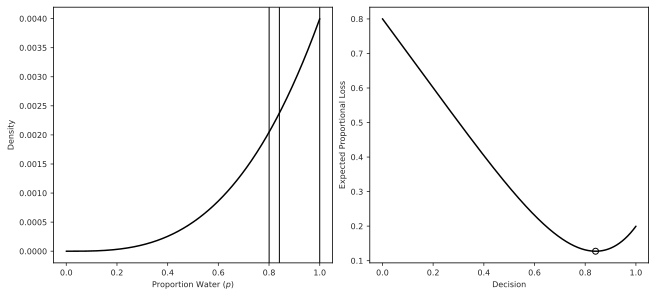

In [ ]:
mode = p_grid[np.argmax(posterior)]
mean = np.sum(p_grid * posterior)
median_idx = np.searchsorted(np.cumsum(posterior), 0.5, side='right')
median = p_grid[median_idx]
loss = loss_function_median(p_grid, posterior)


_, axs = plt.subplots(1, 2, figsize=(9, 4))

ax = axs[0]
ax.plot(p_grid, posterior, color='k')
ax.axvline(mean, color='k', linewidth=1)
ax.axvline(median, color='k', linewidth=1)
ax.axvline(mode, color='k', linewidth=1)
ax.set_xlabel('Proportion Water ($p$)')
ax.set_ylabel('Density')

ax = axs[1]
ax.plot(p_grid, loss, 'k')
ax.plot(p_grid[np.argmin(loss)], np.min(loss), 'o', color='k', markerfacecolor='none')
ax.set_xlabel('Decision')
ax.set_ylabel('Expected Proportional Loss')

for i in range(2):
    axs[i].spines[['right', 'top']].set_visible(True)